 # ARIMA based on top x crimes

In [1]:
TOP_X_CRIMES = 10 

## Imports

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import os
import pickle
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import root_mean_squared_error
from math import sqrt
from pmdarima import auto_arima
import seaborn as sns
from collections import defaultdict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data

In [3]:
path = '..\\data\\mergedData\\ts_df.csv'
ts_df = pd.read_csv(path)
ts_df = ts_df.loc[:, ~ts_df.columns.str.contains('^Unnamed')]
ts_df.head()

,Reported_Date,dist_id,Offense_Cluster,Cluster_Name,Cluster_Description,lon,lat
0,2015-03-06,6.0,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w...",-94.5767,38.9767
1,2015-09-08,3.0,26,Auto Theft,"Incidents involving auto theft, theft, and aut...",-94.5516,39.0947
2,2015-05-19,3.0,14,Possession Sale,"Incidents involving possession sale, distribut...",-94.5461,39.0735
3,2015-08-31,1.0,20,Assault,"Incidents involving non-aggravated assault, ag...",-89.0251,42.2167
4,2015-12-04,3.0,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w...",-94.5645,39.0952


## Time Series per Crime per District

In [4]:
dist_ids = ts_df.dist_id.unique()
dist_ids = sorted(dist_ids)
print("dist_ids", dist_ids)
num_dists = len(dist_ids)
print("num_dists", num_dists)

dist_ids [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
num_dists 6


In [5]:
cluster_names = ts_df.Cluster_Name.unique()
cluster_names = sorted(cluster_names)
print("cluster_names", cluster_names)
num_cluster_names = len(cluster_names)
print("num_cluster_names", num_cluster_names)

cluster_names ['Aggravated Assault', 'Alcohol Influence', 'Armed Robbery', 'Arson', 'Assault', 'Auto Accessory Theft', 'Auto Parts Theft', 'Auto Theft', 'Building Theft', 'Burglary', 'Child Abuse', 'Credit Debit', 'Dead Body', 'Disorderly Conduct', 'Distribution Controlled Substance', 'Domestic Assault', 'Domestic Burglary', 'Domestic Violence', 'Domestic Violence Property', 'Driving Influence', 'Eluding Resisting', 'Embezzlement', 'Ex Parte', 'Family Offense', 'Felon Prohibited Person Possession Firearm', 'Forgery', 'Fraud', 'Fraudulent Use Credit', 'Hit Run', 'Identity Theft', 'Impersonation', 'Intimidation', 'Investigation', 'Miscellaneous Violation', 'Municipal Warrant Arrest', 'Murder', 'Possession Drug', 'Possession Sale', 'Property Damage', 'Rape', 'Recovered Stolen', 'Resisting Officer', 'Robbery', 'Scam', 'Sexual Assault', 'Sexual Misconduct', 'Shoplifting', 'Sodomy', 'Stolen Auto', 'Stolen Property', 'Strong Arm Robbery', 'Terroristic Threats', 'Theft', 'Trespassing', 'Vehicu

In [6]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    # Filter data for this district
    dist_data = ts_df[ts_df['dist_id'] == dist_id]
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        crime_data = dist_data[dist_data['Cluster_Name'] == cluster_name]
        # Prepare ts data and split
        train = crime_data.loc[crime_data.Reported_Date < "2024-01-01"]
        test = crime_data.loc[crime_data.Reported_Date >= "2024-01-01"]
        train = train.groupby("Reported_Date").size().reset_index(name='Crime_Count')
        test = test.groupby("Reported_Date").size().reset_index(name='Crime_Count')
        train.index = pd.to_datetime(train.Reported_Date)
        test.index = pd.to_datetime(test.Reported_Date)
        train = train.asfreq('d', fill_value=0)
        test = test.asfreq('d', fill_value=0)
        train = train.drop(columns=['Reported_Date'])
        test = test.drop(columns=['Reported_Date'])
        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [7]:
print(f"number of datasets in dict: {num_dists*num_cluster_names}")
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs[1.0].keys()}")
print(f"test/train in dict: {crime_dist_dfs[1.0]['Alcohol Influence'].keys()}")

number of datasets in dict: 354
districts in dict: dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
crimes in dict: dict_keys(['Aggravated Assault', 'Alcohol Influence', 'Armed Robbery', 'Arson', 'Assault', 'Auto Accessory Theft', 'Auto Parts Theft', 'Auto Theft', 'Building Theft', 'Burglary', 'Child Abuse', 'Credit Debit', 'Dead Body', 'Disorderly Conduct', 'Distribution Controlled Substance', 'Domestic Assault', 'Domestic Burglary', 'Domestic Violence', 'Domestic Violence Property', 'Driving Influence', 'Eluding Resisting', 'Embezzlement', 'Ex Parte', 'Family Offense', 'Felon Prohibited Person Possession Firearm', 'Forgery', 'Fraud', 'Fraudulent Use Credit', 'Hit Run', 'Identity Theft', 'Impersonation', 'Intimidation', 'Investigation', 'Miscellaneous Violation', 'Municipal Warrant Arrest', 'Murder', 'Possession Drug', 'Possession Sale', 'Property Damage', 'Rape', 'Recovered Stolen', 'Resisting Officer', 'Robbery', 'Scam', 'Sexual Assault', 'Sexual Misconduct', 'Shoplifting', 'Sodomy', 'Stol

In [8]:
crime_dist_dfs[1.0]['Alcohol Influence']["train"].head()

,Crime_Count
Reported_Date,
2019-04-09,1
2019-04-10,0
2019-04-11,0
2019-04-12,0
2019-04-13,0


### Filter out crimes with low counts

> keep only top x crimes

In [9]:
def get_top_x_crimes(crime_dist_dfs, X = 10):
    # Step 1: Aggregate crime counts across dates and districts
    total_crime_counts = defaultdict(int)

    for district, crimes in crime_dist_dfs.items():
        for crime, data_dict in crimes.items():
            # Sum the Crime_Count column for the 'train' DataFrame of each crime
            total_crime_counts[crime] += data_dict["train"]["Crime_Count"].sum()

    # Step 2: Sort crimes by count in descending order and extract the top X crimes
    X = X  # Specify the number of top crimes to retrieve
    top_crimes_set = sorted(total_crime_counts.items(), key=lambda x: x[1], reverse=True)[:X]
    
    top_crimes = []
    # Display the top X crimes
    for crime, count in top_crimes_set:
        print(f"{crime}: {count}")
        top_crimes.append(crime)

    # Step 3: Filter `crime_dist_dfs` to retain only the top X crimes
    filtered_crime_dist_dfs = {
        district: {crime: data_dict for crime, data_dict in crimes.items() if crime in top_crimes}
        for district, crimes in crime_dist_dfs.items()
    }

    # `filtered_crime_dist_dfs` now contains only the top X crimes
    return filtered_crime_dist_dfs

In [10]:
crime_dist_dfs = get_top_x_crimes(crime_dist_dfs, X = TOP_X_CRIMES)

Auto Theft: 97053
Property Damage: 71590
Burglary: 61688
Domestic Assault: 58957
Aggravated Assault: 50526
Assault: 46546
Shoplifting: 46063
Sexual Assault: 41548
Domestic Violence: 35351
Stolen Auto: 35063


### Auto arima

In [11]:
def test_adf_stationary(data):
    result = adfuller(data)

    if result[1] > 0.05:
        return False
    else:
        return True

In [12]:
# Loop through each district and crime category
for dist_id, crimes in crime_dist_dfs.items():
    for cluster_name, data_splits in tqdm.tqdm(crimes.items(), desc=f"dist {dist_id} Crimes", leave=False):
        train_data = data_splits["train"]
        test_data = data_splits["test"]
        
        try:
            # Check if stationary
            is_stationary = test_adf_stationary(train_data["Crime_Count"])
            
            # Fit the ARIMA model
            arima_model = auto_arima(train_data, seasonal=False, stationary=is_stationary, stepwise=True, trace=False, error_action="ignore")
            
            # Save model configuration
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = {
                "p": arima_model.order[0],
                "d": arima_model.order[1],
                "q": arima_model.order[2],
                "aic": arima_model.aic()
            }

            residuals = arima_model.resid()

            # Perform Shapiro-Wilk test on residuals
            shapiro_test_statistic, p_value = shapiro(residuals)

            # Interpretation
            if p_value > 0.05:
                raise Exception("**Residuals are normally distributed (fail to reject H0).**")

            # Determine the number of predictions
            n_predictions = len(test_data) if len(test_data) > 0 else 265
            
            # Generate predictions
            predictions = arima_model.predict(n_periods=n_predictions)
            
            # Calculate RMSE if test data is available
            if len(test_data) > 0:
                rmse = root_mean_squared_error(test_data, predictions)
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse"] = rmse
            else:
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse"] = None

            # Save predictions and residuals in data structure
            crime_dist_dfs[dist_id][cluster_name]["forecast"] = predictions
            crime_dist_dfs[dist_id][cluster_name]["residuals"] = residuals
            
        except Exception as e:
            print(f"ARIMA model failed for district {dist_id}, crime {cluster_name} with error: {e}")
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = None  # If fitting fails

#### Plotting

In [16]:
def plot_crime_forecast(train_data, test_data, forecast_data, crime_type="Unknown Crime", district_id="Unknown District"):
    """
    Plots the training data, test data, and forecasted data in one plot.
    """
    
    plt.figure(figsize=(20, 6))
    
    # Plot training data
    plt.plot(train_data, label="Training Data", color="blue")
    
    # Plot test data
    plt.plot(test_data, label="Test Data (Actual)", color="green")
    
    # Plot forecast data
    plt.plot(forecast_data, label="Predictions", color="red", linestyle="--")
    
    # Formatting the plot
    plt.title(f"Crime Forecast for {crime_type} in District {district_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of Crimes")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

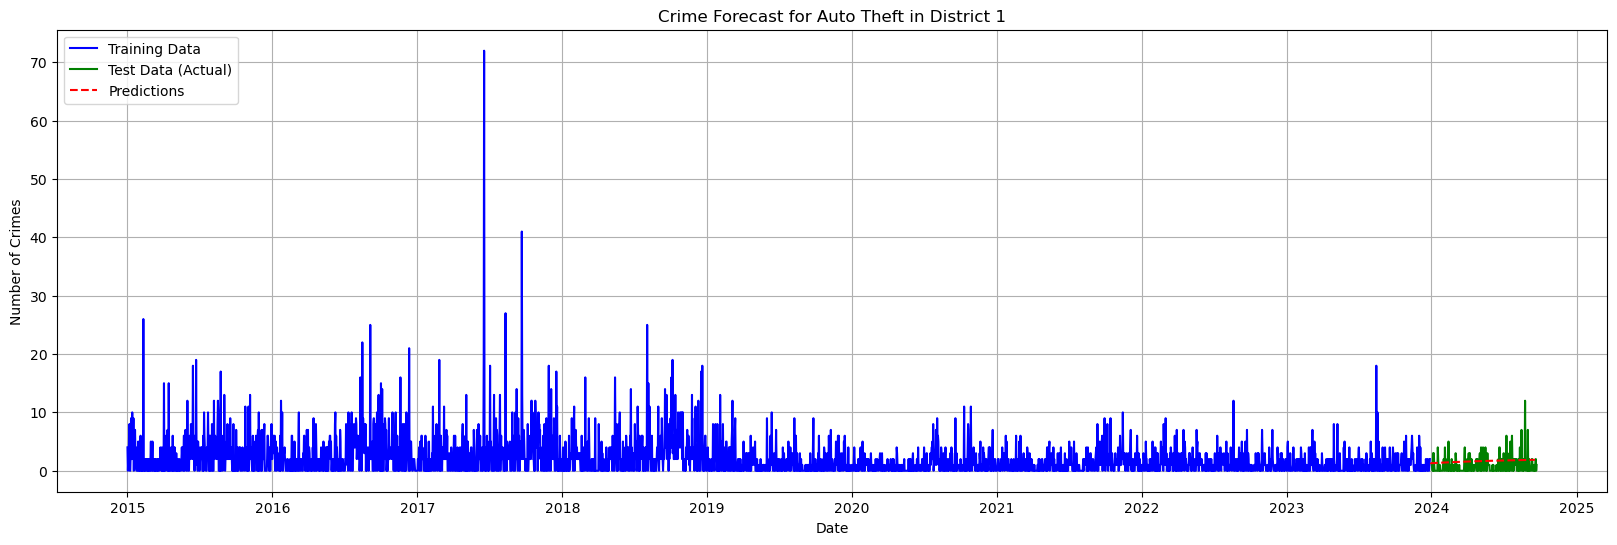

In [17]:
plot_crime_forecast(crime_dist_dfs[1.0]['Auto Theft']["train"], crime_dist_dfs[1.0]['Auto Theft']["test"], crime_dist_dfs[1.0]['Auto Theft']["forecast"], crime_type="Auto Theft", district_id=1)

In [20]:
def plot_rmse_heatmap(crime_dist_dfs):
    """
    Function to create a heatmap plot of RMSE values for crimes across districts
    """
    # Initialize an empty dictionary to hold RMSE values
    rmse_data = {
        "District": [],
        "Crime": [],
        "RMSE": []
    }
    
    # Collect RMSE values for each crime in each district
    for dist_id, crimes in crime_dist_dfs.items():
        for crime_name, crime_info in crimes.items():
            if crime_info.get("model_config") and crime_info["model_config"].get("rmse") is not None:
                rmse_data["District"].append(dist_id)
                rmse_data["Crime"].append(crime_name)
                rmse_data["RMSE"].append(crime_info["model_config"]["rmse"])
    
    # Create a DataFrame from the collected RMSE data
    rmse_df = pd.DataFrame(rmse_data)
    rmse_pivot = rmse_df.pivot(index="Crime", columns="District", values="RMSE")
    
    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
    plt.title("RMSE of Crime Predictions by District and Crime Category")
    plt.xlabel("District")
    plt.ylabel("Crime Category")
    plt.tight_layout()
    plt.show()

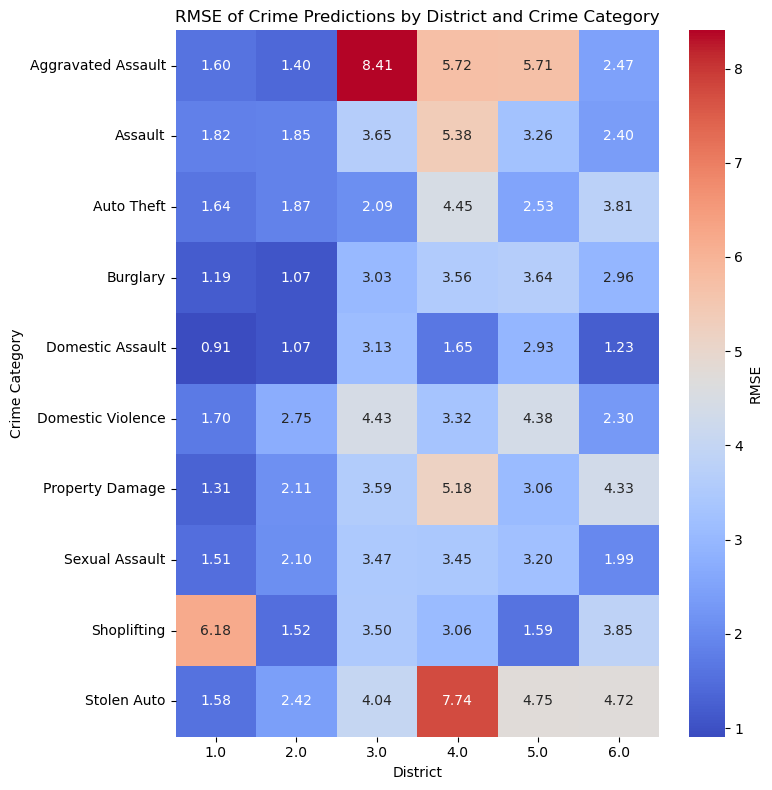

In [21]:
plot_rmse_heatmap(crime_dist_dfs)

In [22]:
# Save dictionary to a pickle file
with open(f"..\\data\\mergedData\\crime_dist_dfs_top_{TOP_X_CRIMES}.pkl", 'wb') as file:
    pickle.dump(crime_dist_dfs, file)

In [ ]:
# Load dictionary from a pickle file
#with open(f"..\\data\\mergedData\\crime_dist_dfs_top_{TOP_X_CRIMES}.pkl", 'rb') as file:
#    crime_dist_dfs = pickle.load(file)

### Automatic pipeline

---